<a href="https://colab.research.google.com/github/arponmandal/RNN-LSTM-with-Time-Series-Data/blob/main/Assignment(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RNNs to predict time series


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

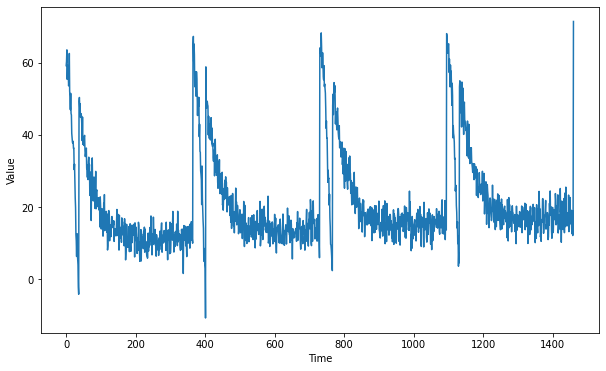

In [ ]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data




In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

In [ ]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [ ]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    learning_rate = 2e-6
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 6s 53ms/step - loss: 18.3211 - mae: 18.8174 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 39ms/step - loss: 6.6365 - mae: 7.1120 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 40ms/step - loss: 4.3536 - mae: 4.8114 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 39ms/step - loss: 4.1439 - mae: 4.6068 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 40ms/step - loss: 4.0076 - mae: 4.4684 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 40ms/step - loss: 3.9345 - mae: 4.3921 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 41ms/step - loss: 3.8256 - mae: 4.2863 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 42ms/step - loss: 3.8098 - mae: 4.2748 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 40ms/step - loss: 3.6375 - mae: 4.1018 - lr: 2

Epoch 74/100
34/34 [==============================] - 1s 42ms/step - loss: 52.3951 - mae: 52.8919 - lr: 0.0045
Epoch 75/100
34/34 [==============================] - 1s 42ms/step - loss: 27.0217 - mae: 27.5160 - lr: 0.0050
Epoch 76/100
34/34 [==============================] - 2s 43ms/step - loss: 52.5971 - mae: 53.0959 - lr: 0.0056
Epoch 77/100
34/34 [==============================] - 2s 43ms/step - loss: 61.8280 - mae: 62.3275 - lr: 0.0063
Epoch 78/100
34/34 [==============================] - 2s 43ms/step - loss: 78.8565 - mae: 79.3564 - lr: 0.0071
Epoch 79/100
34/34 [==============================] - 1s 40ms/step - loss: 57.1411 - mae: 57.6390 - lr: 0.0079
Epoch 80/100
34/34 [==============================] - 1s 41ms/step - loss: 61.6649 - mae: 62.1617 - lr: 0.0089
Epoch 81/100
34/34 [==============================] - 2s 44ms/step - loss: 167.3488 - mae: 167.8487 - lr: 0.0100
Epoch 82/100
34/34 [==============================] - 1s 40ms/step - loss: 157.2206 - mae: 157.7206 - lr: 0.01

(1e-06, 1.0, 0.0, 30.0)

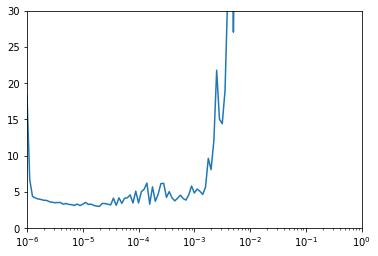

In [ ]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [ ]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    learning_rate = 1e-06
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 8s 78ms/step - loss: 32.5056 - mae: 33.0045
Epoch 2/50
34/34 [==============================] - 2s 66ms/step - loss: 7.1305 - mae: 7.6094
Epoch 3/50
34/34 [==============================] - 2s 66ms/step - loss: 5.6451 - mae: 6.1096
Epoch 4/50
34/34 [==============================] - 2s 66ms/step - loss: 5.1882 - mae: 5.6536
Epoch 5/50
34/34 [==============================] - 2s 64ms/step - loss: 4.9331 - mae: 5.3939
Epoch 6/50
34/34 [==============================] - 2s 64ms/step - loss: 4.8039 - mae: 5.2638
Epoch 7/50
34/34 [==============================] - 2s 61ms/step - loss: 4.6944 - mae: 5.1568
Epoch 8/50
34/34 [==============================] - 2s 63ms/step - loss: 4.6359 - mae: 5.0998
Epoch 9/50
34/34 [==============================] - 2s 66ms/step - loss: 4.5616 - mae: 5.0237
Epoch 10/50
34/34 [==============================] - 2s 66ms/step - loss: 4.5185 - mae: 4.9824
Epoch 11/50
34/34 [==============================] - 2s 6

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

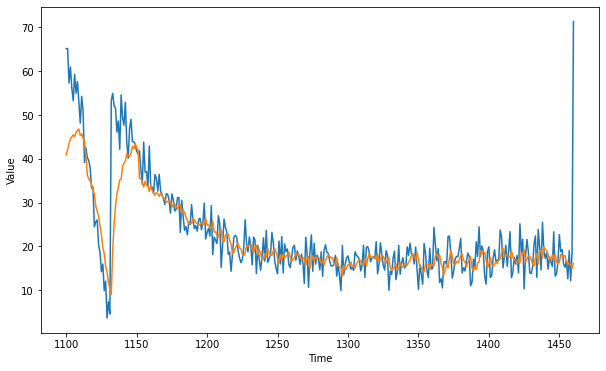

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 42.88, mae: 3.83 for forecast


In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
